# Explicit scheme - with explicit solver


## Overall scheme
The overall perspective of the explicit scheme is to maintain the invariance after the calculation of the new node C. This invariance is assured by checking and adjusting the status of all neighbor faces of node C.

The explicit scheme consists of four mayor steps:

    1. Identify the next face to process; fh = get_next_index
    2. For the explicit triangle solver one additionally needs of acces D
    3. With access to the geometry of the face, calculate C
    4. Uptade face status in the neigbourhood of the new node

## Guarantee the invariance
For all neighbor faces of calculated node C:
    pass to next stage
        * active face passes to obsolete or processed
        * non-active faces, if they count with 2 know nodes, pass to active faces
        
This is done by counting the number of known and unknown nodes, and checking whether the status is adequate or needs to be updated.

A pseudo code that assures the invariance might have the following form:


    if nKnown == 3: [number of knowd nodes]
        if face is active:
            remove face from active
            put face into processed / obsolete faces
        
    if nKnown == 2:
        if face is not active:
            mark face as active
        
Equivalently, the pseudo-code might count with a reversed order:

    if face is active:
        if nKnown == 3:
            pass face from active to obsolete / processed
        elif nKnown == 2:
            pass face to active


## Definitions


In [1]:
import openmesh as om
import numpy as np
import matplotlib.pyplot as plt

# mesh = om.read_trimesh('T40.off')
# mesh = om.read_trimesh('T16.off')
# mesh = om.read_trimesh('T8.off')
# mesh = om.read_trimesh('T4.off')
# mesh = om.read_trimesh('T4b.off')
mesh = om.read_trimesh('T8b.off')

V=mesh.points()

X_MAX = 0.5
Y_MIN = 0.6
#
V[:,0] = V[:,0]*X_MAX / 4
V[:,1] = Y_MIN + (1-Y_MIN)*V[:,1]

X=V[:,0]
Y=V[:,1]


def initActiveNodes():
    ActiveNodeList = []
    for vh in mesh.vertices():
        k = vh.idx()
        if X[k] == 0 or Y[k] == 1:
            ActiveNodeList.append(vh)
    return ActiveNodeList

def initActiveFaceList():
    ActiveFaceList = []

    i=0
    for fh in mesh.faces():
        counter = 0
    
        for vh in mesh.fv(fh):
            if vh in ActiveNodeList:
                # print(vh.idx(),' in ', fh.idx())                
                counter = counter + 1
            
        if counter == 2:
            ActiveFaceList.append(fh)

    return ActiveFaceList

def init_TS_nodes():
    T = np.zeros(len(V))-1
    S = np.zeros(len(V))-1

    for vh in ActiveNodeList:    
        k = vh.idx()
        if X[k] == 0:
            T[k] = 0
            S[k] = 0
        elif Y[k] == 1:
            T[k] = X[k]
            S[k] = X[k]
            # S[k] = 0    
    return T, S

def init_TS_faces():
    Tf = np.zeros(len(mesh.faces()))-1
    Sf = np.zeros(len(mesh.faces()))-1

    for fh in ActiveFaceList:
        T_ABC = 0
        S_ABC = 0
        counter = 0
        for vh in mesh.fv(fh):
            if vh in ActiveNodeList:
                T_ABC = T_ABC + T[vh.idx()]
                S_ABC = S_ABC + S[vh.idx()]            
                counter = counter + 1
            
        if counter != 2:
            print('ERR at face', fh.idx())
        else:
            Tf[fh.idx()] = T_ABC / 2
            Sf[fh.idx()] = S_ABC / 2
            
    return Tf, Sf
    
# routine to get active face indices    
def getActiveFaceIndices():
    I_list = []
    for fh in ActiveFaceList:
        I_list.append(fh.idx())
        
    return I_list

    
def getActiveNodeIndices():
    I_list = []
    for fh in ActiveNodeList:
        I_list.append(fh.idx())

    return I_list


def getProcessedFaceIndices():
    I_list = []
    for fh in ProcessedFaceList:
        I_list.append(fh.idx())
        
    return I_list

def getObsoleteFaceIndices():
    I_list = []
    for fh in ObsoleteFaceList:
        I_list.append(fh.idx())
        
    return I_list

def get_T_C_dummy(T_A, T_B):
    return (T_A + T_B)/2 + 10

# ... update faces: done inline    

def getAngle(v1, v2):
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))    
    return angle

def getGrad2(I, U):
    m = np.zeros((2, 2))
    b = np.zeros((2, 1))

    for k in range(2):
        m[k,0] = X[I[k+1]] - X[I[0]]
        m[k,1] = Y[I[k+1]] - Y[I[0]]
        b[k] = U[k+1]-U[0]
                
    g = np.linalg.solve(m, b)    
    c = np.linalg.cond(m)

    return c, g

def any():
    global global_I
    print('(any)',global_I)
    
def test():
    print(S)
    print(T)    


ActiveNodeList = initActiveNodes()
ActiveFaceList = initActiveFaceList()
    
T, S = init_TS_nodes()
Tf, Sf = init_TS_faces()

I_active_faces = getActiveFaceIndices()
print(len(I_active_faces), 'active faces:', I_active_faces)



52 active faces: [28, 29, 39, 41, 42, 80, 81, 119, 121, 136, 138, 141, 167, 168, 176, 218, 222, 224, 226, 367, 369, 379, 381, 388, 389, 394, 397, 399, 404, 426, 427, 430, 435, 497, 499, 569, 573, 652, 653, 726, 786, 789, 908, 911, 961, 965, 1022, 1026, 1082, 1083, 1148, 1152]


## getC

In [2]:
import math
global_I = [25, 20, 46]

def getC(I):
    global cond_M
    # global global_I
    # print('(getC)>', global_I, I)
    # global_I = I
    global global_id_D
    id_D = global_id_D
    # swap indices to guarantee order T_A < T_B
    if T[I[0]] > T[I[1]]:
        I[0], I[1] = I[1], I[0]
        
    T_A=T[I[0]]
    S_A=S[I[0]]
    T_B=T[I[1]]
    S_B=S[I[1]]
        
    x_A = V[I[0],0:2]
    x_B = V[I[1],0:2]
    x_C = V[I[2],0:2]
    x_D = V[id_D,0:2]
    
    if abs(T_B - T_A < 1e-7) or (id_D == -1):
        # id_D = I[1] # id_B
        zeta = 1
        x_zeta = x_B
    else:
        T_D=T[id_D]        
        zeta = (T_A - T_D) / (T_B - T_D)
        x_zeta = (1-zeta)*x_D + zeta*x_B
        
    
    t_A = x_A - x_zeta
    n_A = np.zeros(2)
    n_A[0] = t_A[1]
    n_A[1] = -t_A[0]
    n_A = n_A / (n_A[0]**2 + n_A[1]**2 + 1e-7)**(1/2)
    
    ###################################
    
    M = np.zeros((2, 2))
    b = np.zeros((2, 1))
    xAB = x_B - x_A
    xCA = x_C - x_A

    M[0,0]=xAB[0]; M[1,0]=xAB[1]; M[0,1]=n_A[0]; M[1,1]=n_A[1];
    # M[0,0]=1; M[1,0]=2; M[0,1]=3; M[1,1]=4;
    # b

    cond_M = np.linalg.cond(M)
    
    # if the matrix turns out to be singular (or with very large condition number), then reference values are set,
    # print('cond:', cnd) # , '\n', M)
    if cond_M < 1e9: # math.isinf(cnd):
        p = np.linalg.solve(M, xCA)
        xi = p[0]
        delta_X = p[1]
    else:
        print('ERR: condition number', I, cond_M,'\n', M, '\n', xCA)
        print('t_A:', t_A, 'n_A', n_A, '\n\n\n\n')
        # is_boundary
        xi = 1/2
    
    ###########################################################    
    # allways this value [safety option]
    # xi = 1/3
    
    # debugging
    if zeta < 0 or zeta > 1 or xi < 0 or xi > 1:
        print('\n zeta:', zeta, '\t xi:', xi)
                
            
    x_xi = (1-xi)*x_A + xi*x_B 
    delta_X = np.linalg.norm(x_xi - x_C)

    T_xi = (1-xi)*T_A + xi*T_B
    S_xi = (1-xi)*S_A + xi*S_B

    S_C = S_xi + delta_X    
    y_C = x_C[1]
    
    # slowliness = S_C / (y_C+1e-7)    
    slowliness = ((S_C / (y_C+1e-7)) + (S_xi / (x_xi[1]+1e-7)))/2
    # slowliness = (S_xi / (x_xi[1]+1e-7))
   
    slowliness = 0.1 / (y_C+0.01)
    
    # slowliness = S_xi / (x_xi[1] + 1e-7)
    # slowliness = 1 / (x_xi[1] + 1e-7)
    # slowliness = (x_xi[1] + 1e-7)
    

    # slowliness = x_A[0]    

    # slowliness = 1 + 0.5*x_C[1] # ok
    # slowliness = 1 + 4*x_C[0]
    slowliness = 1 + 8*x_C[0]    
    
    if slowliness > 1e3:
        print('slowliness too fast: %.2f' % slowliness, '\t S: %.2f' % S_C, 'y: %.2f' % y_C)
        slowliness = 11
    
    T_C = T_xi + delta_X*slowliness
    
    return T_C, S_C

I = [15, 10, 38]; global_id_D = -1
# I = [27, 56, 48]; global_id_D = -1
# I = [0, 30, 50]; global_id_D = 5

TC, SC = getC(I)
print('%.2f' % TC, '%.2f' % SC)



 zeta: 1 	 xi: 2.2
-0.92 -0.96


## Identification of D

The point "D" is assigned as global variable, such that one can access from the calculating subroutine, without changing the general format that might be applicable to the implicit solver.

There are different characterizations of the node D

    * D is in the neighbor cell which does not contain C; the node D is the opposing node; 
    but we do not necessaryly want to put either node A, B or C as an argument for the subroutin, in order to not overload the argument list, such taht is consisten with other implementations that do not need access to the point D, like for implicit triangle solvers
    
    * if D is characterized by belonging to the face at the sied of the edge AB without C,
    how can we acces to the edge AB, how can we access to the faces at the side of the edge.
    
    * within the grid routine we can identify the processed or obsolet faces by their lists: the node D is at the neighbor face that is processed or obsolete, i.e the face ABD is that face neighbor of ABC that has 3 known nodes; (the other faces contain C, so they have less known nodes); node D is that node in ABD that is not contained in ABC; that unique face without C is the face ABD; given that the values of A, B are known, the face ABD is processed or obsolete.
    
    
    
    for "neighbor face (ffh)" of "fh":
        if ffh is processed or obosolete:
        obtener "D" (by vh or id)
        
        for vh in vertex of identified neighbor face:
            if vh is processed (not A or B)
                then we have D identified

In [3]:
def get_id_D(fh):
    id_D = -1
    
    counter = 0
    counter2 = 0    
    for ffh in mesh.ff(fh):
        if (ffh in ProcessedFaceList) or (ffh in ObsoleteFaceList):
            fh_D = ffh
            counter = counter + 1
            
    if counter == 1:
        for vh in mesh.fv(fh_D):
            if vh not in mesh.fv(fh):
                id_D = vh.idx()
                counter2 = counter2+1
    
    # If the face ABC is at the initial boundary, then there is no backward "D"
    # So, D is set to A or B, to (1) have some value that makes zeta=1, and thus x_{zeta} = x_B
    # ... this handling of D should be done in the main routine
    #
    # if counter!=1 or counter2 != 1:
    #    counter3 = 0
    #    for vh in mesh.fv(fh):
    #        if vh in ActiveFaceList:
    #            id_D = vh.idx()
    #            counter3 = counter3 + 1
    
    # ...all these errors are captured by identifying id_D = -1 in the superior routine
        #if counter3 > 0:
        #    print('face on boundary; D = A or B')
        #else:
        #    print('ERR: face with D could not be idenfified:', counter, counter2, counter3)        
        
    # if id_D == -1:
    #    print('no id calculated [!]')
        
    return id_D


def fh_to_index_set(fh):
    counter = 0
    for vh in mesh.fv(fh):
        if vh in ActiveNodeList:
            # print(vh.idx(),'ingoing')
            if counter == 0:
                counter = counter + 1
                id_A = vh.idx()              
            elif counter == 1:
                counter = counter + 1
                id_B = vh.idx()
            else:
                print('ERR: too many ingoing nodes')                
        else:
            # print(vh.idx(),'outgoing')        
            id_C = vh.idx()
            
    if counter != 2:
        print('ERR: missing inputs for calculating T_C')
        
    I_ABC = [id_A, id_B, id_C]
    return I_ABC

# Explicit scheme

In [8]:
import sys
print('redirect screen output into file')
sys.stdout = open('foam-explicit-out-put.txt', 'w') # screen output into file 

####################

ProcessedFaceList = []
ObsoleteFaceList = []

ActiveNodeList = initActiveNodes()
ActiveFaceList = initActiveFaceList()

T, S = init_TS_nodes()
Tf, Sf = init_TS_faces()

global global_I
global global_id_D

def nextFace():
    # (0) update the index    
    I_active_faces = getActiveFaceIndices()
    I = np.array(I_active_faces)
    K = np.argsort(Tf[I], axis=0)
    
    next_face_id = (I[K])[0]
    fh = mesh.face_handle(next_face_id)
    
    return fh


# print('len: list(I[K]) \t \t (id_A, id_B) -> id_C \n \n \n')
j=0
while len(ActiveFaceList)>0:
    j=j+1    

    # (1) obtain id of next face    
    fh = nextFace()
    id_D = get_id_D(fh)
    global_id_D = id_D
        
    # (2) calculate value of outgoing vertex
    
    I_ABC = fh_to_index_set(fh)
    T_C, S_C = getC(I_ABC)

    id_A = I_ABC[0]
    id_B = I_ABC[1]
    id_C = I_ABC[2]
    T[id_C] = T_C
    S[id_C] = S_C    

    # (3) handle the list of active faces    
    vh_C = mesh.vertex_handle(id_C)

    if (not vh_C in ActiveNodeList):
        ActiveNodeList.append(vh_C) # also ! 
    else:
        print('node already listed:', vh_C.idx())
        
    ActiveFaceList.remove(fh)
    ProcessedFaceList.append(fh)

    # (3b) agregate new faces to the list
    f_list = []
    
    # ...
    I_active_faces = getActiveFaceIndices()
    I = np.array(I_active_faces)
    K = np.argsort(Tf[I], axis=0)    
    
    # print('(main)', global_I,': %.2f' % T_C, '%.2f' % S_C, '\n\n')    
    # print('T:', T[I_ABC], 'S:', S[I_ABC])
    # print('(', id_A, ',', id_B, ') ->', id_C,'\t \t',len(I_active_faces),': ', list(I[K]))
    
    print('(', id_A, ',', id_B, ') ->', id_C, ', \t D:', id_D, '\t \t',' %.2f' % T_C, '%.2f' % S_C,'; \t', len(I_active_faces),': ', list(I[K])) # ,'\n\n')

    
    for fvh in mesh.vf(vh_C):
        f_list.append(fvh.idx())
        # print('fv', fvh.idx())
        
        # quick check whether the face is obsolete,
        # which is a normal situation that should not be handled as an error
        # but by moving on to the next face

        # face is registered as active, but contains 3 known nodes
        if fvh in ActiveFaceList:    
            counter = 0
            for vh in mesh.fv(fvh):
                if vh in ActiveNodeList:
                    counter = counter + 1    
            if counter == 3:
                # print('remove obsolete face:', fh.idx())
                ObsoleteFaceList.append(fvh)
                ActiveFaceList.remove(fvh)
                # continue           
        
        # face is not registered as activ, but has 2 known nodes, and 1 unknown
        elif (not fvh in ActiveFaceList) and (not fvh in ProcessedFaceList):
            counter = 0
            for vh in mesh.fv(fvh):
                if vh in ActiveNodeList:
                    counter = counter + 1
        
            if counter == 2:
                ActiveFaceList.append(fvh)
                # print('new face:', fvh.idx())
                Tf[fvh.idx()] = T_C # [!]
                
                # counter = 0
                # for vh in mesh.fv(fvh):
                #    if vh in ActiveNodeList:
                #        if counter == 0:
                #            T_A = T[vh.idx()]
                #            counter = counter + 1
                #        elif counter == 1:
                #            T_B = T[vh.idx()]
                #    # Tf[fvh.idx()] = (T_A + T_B)/2
                #    Tf[fvh.idx()] = max(T_A, T_B)   
            
            elif counter == 3:
                print('face duplicate registered:', fvh.idx())                
    
    if False:
    # if j>21:
        print('debugging...')
        break
        

redirect screen output into file


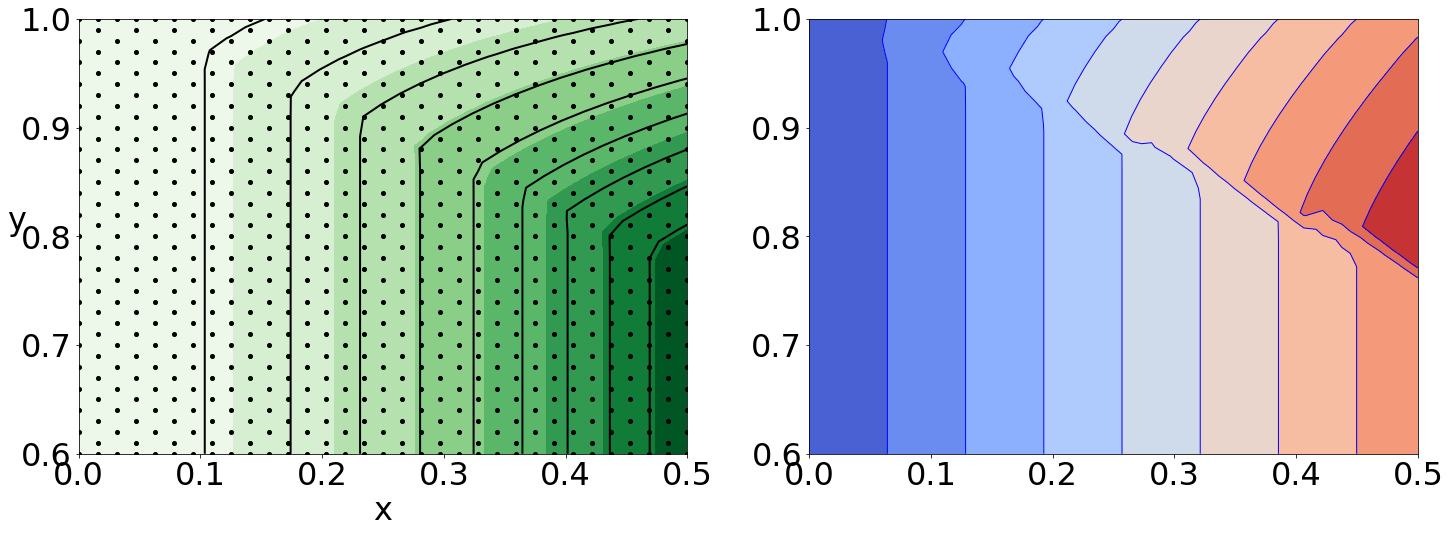

In [9]:
plt.rcParams.update({'font.size': 32})

cmap = plt.get_cmap('Greens')
cmap2 = plt.cm.coolwarm
levels1 = np.linspace(min(T), max(T), 11)
levels2 = np.linspace(min(S), max(S), 11)

fig, (plt1, plt2) = plt.subplots(ncols=2, figsize=(24, 8))

plt1.plot(X, Y, '.k', markersize=8)
plt1.tricontourf(X, Y, T, cmap=cmap, zorder=1); # extent=[x0, y0, x1, y1],
plt1.tricontour(X, Y, T, colors='k', linewidths=2, levels=levels1);
# plt1.tricontour(X, Y, S, colors='b' , zorder=1, linewidths=1, levels=levels2)

plt1.set_xlabel("x", fontsize=32)
h1=plt1.set_ylabel("y", fontsize=32)
h1.set_rotation(0)
plt.savefig('Tviz')

plt2.tricontourf(X, Y, S, cmap=cmap2 , zorder=1, levels=levels2);
plt2.tricontour(X, Y, S, colors='b' , zorder=1, linewidths=1, levels=levels2);



In [10]:
print('\n T: \n', T)
print('\n Tf: \n', Tf)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in add
  app.launch_new_instance()


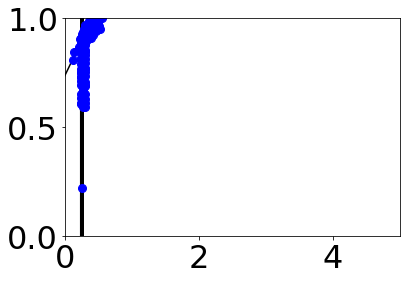

In [7]:
def getContour(q_T):
    j=0
    C_list = []
    for eh in mesh.edges():
        j=j+1
        # print(eh.idx())
        heh = mesh.halfedge_handle(eh, 0)
        vh1 = mesh.from_vertex_handle(heh)
        vh2 = mesh.to_vertex_handle(heh)    

        k1 = vh1.idx()
        k2 = vh2.idx()
        if (T[k1] - median_T)*(T[k2] - q_T) < 0:
            # print(eh.idx(),':', vh1.idx(), vh2.idx())    
            alpha = (median_T - T[k1])/(T[k2] - T[k1])
            Vm = (alpha*V[k1,0:2]+(1-alpha)*V[k2,0:2])
            C_list.append(Vm)

    C_list = np.array(C_list)
    I=np.argsort(C_list[:,0])
    C_sort=C_list[I,:]
    return C_sort
    
#  128 : 9 14

median_T = np.median(T)
quintiles = np.percentile(T, [20,40,60,80])
XY = getContour(quintiles[2])
plt.xlim(0, 5)
plt.ylim(0, 1)

plt.plot(XY[:,0], XY[:,1], '.-k', markersize=2)
plt.plot(XY[:,0], XY[:,1], 'ob', markersize=8)    
